Es hora de concentrarnos en la construcción de modelos, comencemos con un modelo base de regresión logistica, es relativamente simple, pero puede sorprendernos con su gran rendimiento en problemas de clasificación.

Punto importante: en problemas de detección de fraudes, generalmente nos interesa conocer todos los casos con ocurrencia de fraude, aún si ésto implica detectar transacciones que quizá sean legítimias y clasificarlas como fraudelantas. Ésto se debe a que clasificar erróneamente un transacción auténtica como fraudelante se puede corregir con una por llamada al cliente, por mensaje o una confirmación de la operación a través de la app del banco; sin embargo, un transacción clasificada como didedigna que en realidad era fraudelenta términara siendo una pérdida económica para el cliente y muchas veces también para el banco cuando los clientes esten asegurados.

No quiere decir que nos da igual clasificar una operación auténtica como fraudelenta, al contrario, se sabe que eso puede causar molestias a los clientes, y de hecho evitar esas situaciones es también parte del objetivo, sinn embargo, en casos donde se deba sacificar una métrica u otra, debemos poner en una balanza los costos de las malas clasificaciones de nuestros modelos, y en ese sentido, nos interesa tener el máxino nivel de Recal posible.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import os
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [3]:
os.chdir('/content/drive/MyDrive/data_fraud')

Traemos nuestro pipeline de preprocesamiento.

En este caso, como vamos a utilizar la regresión logistica, debemos comentar las transformaciones que hicimos antes de nuestros escalamiento, ya que, dichas transformaciones pueden eliminar relaciones lineales entre nuestros datos, probemos eso y veamos que sucede.

In [6]:
#supongamos que aquí llamamos a nuestros datos de entrenamiento
train_data = pd.read_csv('train.csv')

# Definimos la función para eliminar columnas
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Columnas con alta cardinalidad
        high_cardinality_cols = ['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo']

        # Columnas con muchos valores nulos (umbral 50%)
        null_cols = ['dist1', 'dist2', 'D2', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M5', 'M7',
                    'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141',
                    'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
                    'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169',
                    'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183',
                    'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197',
                    'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
                    'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225',
                    'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239',
                    'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253',
                    'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267',
                    'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V322', 'V323', 'V324',
                    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
                    'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
                    'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
                    'id_26', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']

        # Columnas constantes
        constant_cols = ['V305']

        # Columnas altamente correlacionadas
        corr_cols = {'V62', 'V84', 'C2', 'C11', 'V302', 'C14', 'V45', 'V301', 'V65', 'V280', 'V279', 'V299', 'V308', 'V76', 'C12',
                    'V309', 'V42', 'C6', 'C9', 'V64', 'V73', 'V33', 'V134', 'V137', 'V93', 'V94', 'V28', 'V90', 'V38', 'V125', 'V136',
                    'V119', 'V307', 'V30', 'V79', 'V60', 'V24', 'V113', 'V128', 'V48', 'V34', 'V22', 'V70', 'V91', 'V133', 'V291',
                    'V40', 'V97', 'V285', 'V292', 'C4', 'V36', 'V49', 'V105', 'V87', 'V294', 'V32', 'V284', 'V109', 'V306', 'V289',
                    'V297', 'V106', 'V124', 'V88', 'V102', 'V89', 'V31', 'V316', 'V16', 'V63', 'V13', 'V295', 'V101', 'V83', 'V311',
                    'C10', 'V131', 'V72', 'V43', 'V96', 'C13', 'V20', 'V69', 'V112', 'V21', 'V100', 'V318', 'V54', 'V111', 'V123',
                    'V317', 'V303', 'V57', 'V298', 'V18', 'V287', 'V315', 'C7', 'V59', 'V15', 'V52', 'V58', 'V118', 'V320', 'V110',
                    'V78', 'V85', 'V321', 'V312', 'V92', 'V50', 'TransactionDT', 'V127', 'V122', 'V304', 'V81', 'V71', 'V80', 'V74',
                    'V26', 'V116', 'V293', 'V103', 'V310', 'C8', 'V132', 'V51', 'V114', 'V296', 'V68', 'V126'}

        # Columnas no predictivas
        non_predictive_cols = ['TransactionID']

        # Combinamos todas las columnas a eliminar
        all_cols_to_drop = high_cardinality_cols + null_cols + constant_cols + list(corr_cols) + non_predictive_cols

        # Eliminamos las columnas
        X = X.drop(columns=all_cols_to_drop)

        return X

# Funciones de transformación
def log_transform(x):
    return np.log1p(x)

def inverse_log_transform(x):
    x_reflected = x.max() - x  # Reflejamos valores
    return np.log1p(x_reflected)

def sqrt_transform(x):
    return np.sqrt(abs(x))

# Columnas categóricas y numéricas
categorical_features = ['ProductCD', 'card4', 'card6', 'M4', 'M6']
numeric_mean_log_cols = ['V66']
numeric_median_log_cols = ['TransactionAmt', 'card3', 'C1', 'C3', 'C5', 'D3', 'V17',
                           'V23', 'V27', 'V37', 'V39', 'V44', 'V46', 'V47', 'V55', 'V56',
                           'V67', 'V77', 'V86', 'V95', 'V98', 'V99', 'V104', 'V108', 'V115',
                           'V117', 'V120', 'V121', 'V129', 'V130', 'V135', 'V281', 'V282', 'V283',
                           'V286', 'V288', 'V290', 'V300', 'V313', 'V314', 'V319']
numeric_median_sqrt_cols = ['card5', 'D1', 'D4', 'D10', 'D15']
numeric_median_inv_cols = ['addr2', 'V14', 'V25', 'V41', 'V107']
numeric_mean_cols = ['card1', 'card2', 'addr1', 'V12', 'V35', 'V53', 'V61', 'V75']
numeric_median_cols = ['V19', 'V29', 'V82']

# Creamos los transformadores
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_mean_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('log', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler())
])

numeric_median_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('log', FunctionTransformer(log_transform)),
    #('scaler', StandardScaler())
])

numeric_median_sqrt_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('sqrt', FunctionTransformer(sqrt_transform)),
    #('scaler', StandardScaler())
])

numeric_median_inv_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('inv', FunctionTransformer(inverse_log_transform)),
    #('scaler', StandardScaler())
])

numeric_mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('scaler', StandardScaler())
])

numeric_median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
])

# Unir los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean_log', numeric_mean_log_transformer, numeric_mean_log_cols),
        ('num_median_log', numeric_median_log_transformer, numeric_median_log_cols),
        ('num_median_sqrt', numeric_median_sqrt_transformer, numeric_median_sqrt_cols),
        ('num_median_inv', numeric_median_inv_transformer, numeric_median_inv_cols),
        ('num_mean', numeric_mean_transformer, numeric_mean_cols),
        ('num_median', numeric_median_transformer, numeric_median_cols),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el pipeline completo
pipeline = Pipeline(steps=[('drop_columns', DropColumns()),
                           ('preprocessor', preprocessor)])

# Separar el target y las características
X_train = train_data.drop(columns=['isFraud'])
y_train = train_data['isFraud']

# Ajustar el pipeline y transformar los datos
X_train_prepared = pipeline.fit_transform(X_train)

# Ahora X_train_prepared esta listo para ser usado en los algoritmos de entrenamiento

In [7]:
regresion_logistica_1 = LogisticRegression()
regresion_logistica_1.fit(X_train_prepared, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [9]:
y_train_pred_1 = regresion_logistica_1.predict(X_train_prepared)

In [10]:
training_acc_1 = accuracy_score(y_train, y_train_pred_1)
training_recall_1 = recall_score(y_train, y_train_pred_1)

print(f"Accuracy en el conjunto de entrenamiento: {training_acc_1}")
print(f"Recall en el conjunto de entrenamiento: {training_recall_1}")

Accuracy en el conjunto de entrenamiento: 0.9056927271765977
Recall en el conjunto de entrenamiento: 0.0035489595095983223


Sabemos que la regresíón logistica, no puede lidiar con este conunto de datos, ya que el desbalance de datos se nota, por lo que tendremos que generar datos sinteticos utilizando la técnica SMOTE, de ésta forma el modelo podrá aprender de ambas clases.  

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
# generamos nuestra instancia
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X_train_prepared, y_train)

In [13]:
# Nuestro modelo base debe detectar mejor las clases ahora
regresion_logistica_2 = LogisticRegression()
regresion_logistica_2.fit(x_resampled, y_resampled)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [14]:
y_train_pred_2 = regresion_logistica_2.predict(x_resampled)

training_acc_2 = accuracy_score(y_resampled, y_train_pred_2)
training_recall_2 = recall_score(y_resampled, y_train_pred_2)

print(f"Accuracy en el conjunto de entrenamiento: {training_acc_2}")
print(f"Recall en el conjunto de entrenamiento: {training_recall_2}")

Accuracy en el conjunto de entrenamiento: 0.6407803398361653
Recall en el conjunto de entrenamiento: 0.6920807673397278


In [15]:
val_data = pd.read_csv('val.csv')

# separamos nuestra variable onjetivo
X_val = val_data.drop(columns=['isFraud'])
y_val = val_data['isFraud']

# transformamos nuestros datos
X_val_prepared = pipeline.transform(X_val)


In [16]:
# nos da esperanza ese aumento en el Recall, pues podemos ver cambios positivos en nuestro objetivo, ahora el modelo aprende de ambas clases
# en el conjunto de validación
y_val_pred_2 = regresion_logistica_2.predict(X_val_prepared)

valid_acc_2 = accuracy_score(y_val, y_val_pred_2)
valid_recall_2 = recall_score(y_val, y_val_pred_2)

print(f"Accuracy en el conjunto de validación: {valid_acc_2}")
print(f"Recall en el conjunto de validación: {valid_recall_2}")

matriz_confusion = confusion_matrix(y_val, y_val_pred_2)
print("\nMatriz de Confusión:")
print(matriz_confusion)


Accuracy en el conjunto de validación: 0.5966963496703147
Recall en el conjunto de validación: 0.6786837648197436

Matriz de Confusión:
[[23529 16471]
 [ 1328  2805]]


Los resultados no son nada buenos, sigamos buscando mejores hiperparámetros para nuestro entrenamiento.

In [17]:
regresion_logistica_3 = LogisticRegression( C=0.1, solver='liblinear')
regresion_logistica_3.fit(x_resampled, y_resampled)


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=0.1, solver='liblinear')

In [18]:
# veamos los resultados
y_train_pred_3 = regresion_logistica_3.predict(x_resampled)

training_acc_3 = accuracy_score(y_resampled, y_train_pred_3)
training_recall_3 = recall_score(y_resampled, y_train_pred_3)

print(f"Accuracy en el conjunto de entrenamiento: {training_acc_3}")
print(f"Recall en el conjunto de entrenamiento: {training_recall_3}")

Accuracy en el conjunto de entrenamiento: 0.7257810481754015
Recall en el conjunto de entrenamiento: 0.6988474903957533


In [19]:
y_val_pred_3 = regresion_logistica_3.predict(X_val_prepared)

valid_acc_3 = accuracy_score(y_val, y_val_pred_3)
valid_recall_3 = recall_score(y_val, y_val_pred_3)

print(f"Accuracy en el conjunto de validación: {valid_acc_3}")
print(f"Recall en el conjunto de validación: {valid_recall_3}")

matriz_confusion_3 = confusion_matrix(y_val, y_val_pred_3)
print("\nMatriz de Confusión:")
print(matriz_confusion_3)

Accuracy en el conjunto de validación: 0.7454059320689733
Recall en el conjunto de validación: 0.6762642148560368

Matriz de Confusión:
[[30102  9898]
 [ 1338  2795]]


Pareciera que estamos topados con esas metricas, simepre podemos ajustar nuestro umbral de decisión, para que trate de reoconocer mejor los casos de fraude.

In [23]:
y_val_probs = regresion_logistica_3.predict_proba(X_val_prepared)[:, 1]  # Probabilidades de la clase 1
umbral = 0.38 # Ajustamos este valor según los resultados

y_val_pred_3_adjusted = (y_val_probs >= umbral).astype(int)

# Recalculamos las métricas con el nuevo umbral
valid_acc = accuracy_score(y_val, y_val_pred_3_adjusted)
valid_recall = recall_score(y_val, y_val_pred_3_adjusted)

print(f"Accuracy en validación: {valid_acc}")
print(f"Recall en validación: {valid_recall}")

# Matriz de confusión
print(confusion_matrix(y_val, y_val_pred_3_adjusted))


Accuracy en validación: 0.5764167403077063
Recall en validación: 0.8468424872973627
[[21939 18061]
 [  633  3500]]


Sin embargo, aunque capturemos mucho mejor los casos de fraude, la realidad es que estamos afectando mucho las transacciones legítimas, veamos si escalando nuestros datos podemos ver alguna mejora, la expereiencia nos dice que si, pero veamos.

In [24]:
#supongamos que aquí llamamos a nuestros datos de entrenamiento
train_data = pd.read_csv('train.csv')

# Definimos la función para eliminar columnas
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Columnas con alta cardinalidad
        high_cardinality_cols = ['P_emaildomain', 'R_emaildomain', 'id_30', 'id_31', 'id_33', 'DeviceInfo']

        # Columnas con muchos valores nulos (umbral 50%)
        null_cols = ['dist1', 'dist2', 'D2', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'M1', 'M2', 'M3', 'M5', 'M7',
                    'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V138', 'V139', 'V140', 'V141',
                    'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
                    'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169',
                    'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183',
                    'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197',
                    'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
                    'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225',
                    'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239',
                    'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253',
                    'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267',
                    'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V322', 'V323', 'V324',
                    'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
                    'V339', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12',
                    'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
                    'id_26', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']

        # Columnas constantes
        constant_cols = ['V305']

        # Columnas altamente correlacionadas
        corr_cols = {'V62', 'V84', 'C2', 'C11', 'V302', 'C14', 'V45', 'V301', 'V65', 'V280', 'V279', 'V299', 'V308', 'V76', 'C12',
                    'V309', 'V42', 'C6', 'C9', 'V64', 'V73', 'V33', 'V134', 'V137', 'V93', 'V94', 'V28', 'V90', 'V38', 'V125', 'V136',
                    'V119', 'V307', 'V30', 'V79', 'V60', 'V24', 'V113', 'V128', 'V48', 'V34', 'V22', 'V70', 'V91', 'V133', 'V291',
                    'V40', 'V97', 'V285', 'V292', 'C4', 'V36', 'V49', 'V105', 'V87', 'V294', 'V32', 'V284', 'V109', 'V306', 'V289',
                    'V297', 'V106', 'V124', 'V88', 'V102', 'V89', 'V31', 'V316', 'V16', 'V63', 'V13', 'V295', 'V101', 'V83', 'V311',
                    'C10', 'V131', 'V72', 'V43', 'V96', 'C13', 'V20', 'V69', 'V112', 'V21', 'V100', 'V318', 'V54', 'V111', 'V123',
                    'V317', 'V303', 'V57', 'V298', 'V18', 'V287', 'V315', 'C7', 'V59', 'V15', 'V52', 'V58', 'V118', 'V320', 'V110',
                    'V78', 'V85', 'V321', 'V312', 'V92', 'V50', 'TransactionDT', 'V127', 'V122', 'V304', 'V81', 'V71', 'V80', 'V74',
                    'V26', 'V116', 'V293', 'V103', 'V310', 'C8', 'V132', 'V51', 'V114', 'V296', 'V68', 'V126'}

        # Columnas no predictivas
        non_predictive_cols = ['TransactionID']

        # Combinamos todas las columnas a eliminar
        all_cols_to_drop = high_cardinality_cols + null_cols + constant_cols + list(corr_cols) + non_predictive_cols

        # Eliminamos las columnas
        X = X.drop(columns=all_cols_to_drop)

        return X

# Funciones de transformación
def log_transform(x):
    return np.log1p(x)

def inverse_log_transform(x):
    x_reflected = x.max() - x  # Reflejamos valores
    return np.log1p(x_reflected)

def sqrt_transform(x):
    return np.sqrt(abs(x))

# Columnas categóricas y numéricas
categorical_features = ['ProductCD', 'card4', 'card6', 'M4', 'M6']
numeric_mean_log_cols = ['V66']
numeric_median_log_cols = ['TransactionAmt', 'card3', 'C1', 'C3', 'C5', 'D3', 'V17',
                           'V23', 'V27', 'V37', 'V39', 'V44', 'V46', 'V47', 'V55', 'V56',
                           'V67', 'V77', 'V86', 'V95', 'V98', 'V99', 'V104', 'V108', 'V115',
                           'V117', 'V120', 'V121', 'V129', 'V130', 'V135', 'V281', 'V282', 'V283',
                           'V286', 'V288', 'V290', 'V300', 'V313', 'V314', 'V319']
numeric_median_sqrt_cols = ['card5', 'D1', 'D4', 'D10', 'D15']
numeric_median_inv_cols = ['addr2', 'V14', 'V25', 'V41', 'V107']
numeric_mean_cols = ['card1', 'card2', 'addr1', 'V12', 'V35', 'V53', 'V61', 'V75']
numeric_median_cols = ['V19', 'V29', 'V82']

# Creamos los transformadores
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_mean_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    #('log', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler())
])

numeric_median_log_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('log', FunctionTransformer(log_transform)),
    ('scaler', StandardScaler())
])

numeric_median_sqrt_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('sqrt', FunctionTransformer(sqrt_transform)),
    ('scaler', StandardScaler())
])

numeric_median_inv_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('inv', FunctionTransformer(inverse_log_transform)),
    ('scaler', StandardScaler())
])

numeric_mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

numeric_median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Unir los transformadores en un preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean_log', numeric_mean_log_transformer, numeric_mean_log_cols),
        ('num_median_log', numeric_median_log_transformer, numeric_median_log_cols),
        ('num_median_sqrt', numeric_median_sqrt_transformer, numeric_median_sqrt_cols),
        ('num_median_inv', numeric_median_inv_transformer, numeric_median_inv_cols),
        ('num_mean', numeric_mean_transformer, numeric_mean_cols),
        ('num_median', numeric_median_transformer, numeric_median_cols),
        ('cat', categorical_transformer, categorical_features)
    ])

# Crear el pipeline completo
pipeline = Pipeline(steps=[('drop_columns', DropColumns()),
                           ('preprocessor', preprocessor)])

# Separar el target y las características
X_train = train_data.drop(columns=['isFraud'])
y_train = train_data['isFraud']

# Ajustar el pipeline y transformar los datos
X_train_prepared_2 = pipeline.fit_transform(X_train)

# Ahora X_train_prepared esta listo para ser usado en los algoritmos de entrenamiento

Tenemos que volver a generar datos sintéticos para balancear nuestras clases.

In [25]:
# generamos nuestra instancia
smote_2 = SMOTE(random_state=42)
x_resampled_2, y_resampled_2 = smote_2.fit_resample(X_train_prepared_2, y_train)

In [26]:
regresion_logistica_1_2 = LogisticRegression()
regresion_logistica_1_2.fit(x_resampled_2, y_resampled_2)

LogisticRegression()

In [27]:
y_train_pred_1_2 = regresion_logistica_1_2.predict(x_resampled_2)

In [28]:
#veamos los resultados
training_acc_1_2 = accuracy_score(y_resampled_2, y_train_pred_1_2)
training_recall_1_2 = recall_score(y_resampled_2, y_train_pred_1_2)

print(f"Accuracy en el conjunto de entrenamiento: {training_acc_1_2}")
print(f"Recall en el conjunto de entrenamiento: {training_recall_1_2}")

Accuracy en el conjunto de entrenamiento: 0.7356852973774781
Recall en el conjunto de entrenamiento: 0.7313644280369003


In [42]:
val_data = pd.read_csv('val.csv')

# separamos nuestra variable onjetivo
X_val = val_data.drop(columns=['isFraud'])
y_val = val_data['isFraud']

# transformamos nuestros datos
X_val_prepared_2 = pipeline.transform(X_val)


In [43]:
# y en el conjunto de validación
y_val_pred_1_2 = regresion_logistica_1_2.predict(X_val_prepared_2)

valid_acc_1_2 = accuracy_score(y_val, y_val_pred_1_2)
valid_recall_1_2 = recall_score(y_val, y_val_pred_1_2)

print(f"Accuracy en el conjunto de validación: {valid_acc_1_2}")
print(f"Recall en el conjunto de validación: {valid_recall_1_2}")

matriz_confusion_1_2 = confusion_matrix(y_val, y_val_pred_1_2)
print("\nMatriz de Confusión:")
print(matriz_confusion_1_2)

Accuracy en el conjunto de validación: 0.7392200847438425
Recall en el conjunto de validación: 0.7287684490684733

Matriz de Confusión:
[[29612 10388]
 [ 1121  3012]]


Definitivamente fue una buena decisión, pues sabemos que este tipo de técnicas se benefician mucho de tener escalados nuestros datos. Quiza podamos mejorar aun más nuestras métricas aprovechando de mejor forma nuestro conjunto de datos, vamos a aplicar validación cruzada.

In [44]:
# Definimos el modelo
regresion_logistica_4 = LogisticRegression()

# Definimos los hiperparámetros a probar
param_grid = {
    'C': [0.01, 0.1],
    'solver': ['liblinear', 'lbfgs']
}

# Definimos los pliegues para la validación cruzada, en este caso 5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Creamos el objeto GridSearchCV, indicando que el recall es nuestro objetivo
grid_search = GridSearchCV(regresion_logistica_4, param_grid, cv=kfold, scoring='recall')

# Ajusta el modelo a los datos de entrenamiento
grid_search.fit(x_resampled_2, y_resampled_2)

# Imprime los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guarda el mejor modelo
mejor_modelo_de_lr = grid_search.best_estimator_



Mejores hiperparámetros: {'C': 0.01, 'solver': 'liblinear'}


In [45]:
# y en el conjunto de validación
y_val_pred_final= mejor_modelo_de_lr.predict(X_val_prepared_2)

valid_acc_final = accuracy_score(y_val, y_val_pred_final)
valid_recall_final = recall_score(y_val, y_val_pred_final)

print(f"Accuracy en el conjunto de validación: {valid_acc_final}")
print(f"Recall en el conjunto de validación: {valid_recall_final}")

matriz_confusion_final = confusion_matrix(y_val, y_val_pred_final)
print("\nMatriz de Confusión:")
print(matriz_confusion_final)

Accuracy en el conjunto de validación: 0.7394013549951284
Recall en el conjunto de validación: 0.7294943140575852

Matriz de Confusión:
[[29617 10383]
 [ 1118  3015]]


Ahora que tenemos el mejor modelo con los mejores pararámetros que le brindamos, estamos en condiciones de hacer nuestro pipeline final, que incluira la etapa de nuestro preprocesameitno y el mejor modelo.

In [48]:
# Creamos un nuevo pipeline que incluye el preprocesamiento y el modelo
pipeline_final_lr = Pipeline([
    ('preprocesamiento', pipeline),
    ('modelo', mejor_modelo_de_lr)
])

In [49]:
test_data = pd.read_csv('test.csv')
X_test = test_data.drop(columns=['isFraud'])
y_test = test_data['isFraud']

In [50]:
# Evaluamos nuestro pipeline en datos no vistos

y_test_pred = pipeline_final_lr.predict(X_test)

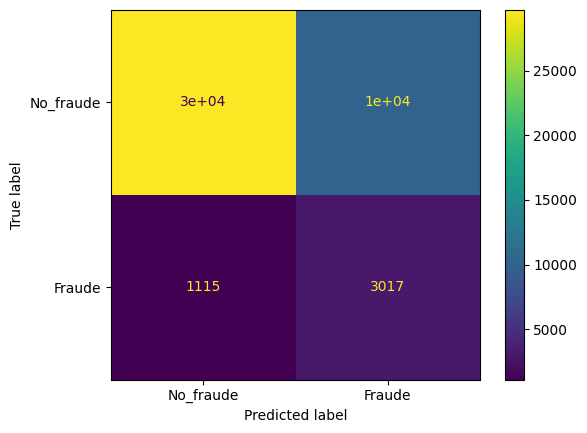

Accuracy en el conjunto de prueba: 0.7408288582240047
Recall en el conjunto de prueba: 0.7301548886737658


In [51]:
# Obtenemos nuestras metricas
test_acc = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# tambien obtenemos nuestra matriz de confussion, pero de una forma más llamtiva
matriz_confusion_test = confusion_matrix(y_test, y_test_pred)

# Visualización de la matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_test,
                                    display_labels=['No_fraude', 'Fraude']) # Reemplaza con tus etiquetas
cm_display.plot()
plt.show()


print(f"Accuracy en el conjunto de prueba: {test_acc}")
print(f"Recall en el conjunto de prueba: {test_recall}")


Como se puede observar, nuestro pipeline final no mejoro mucho comparación con nuestros primeros intentos, siempre tenemos la opción de bajar nuestro umbral de decisión, ya que por regla de negocio, habíamos dicho que maximizar nuestro Recall era el objetivo primordial, ahora, tampoco queremos que nuestro modelo, marque todas las transacciones como fraude, pues realmenete no tendría razon de ser, vamos a ver como quedaría esto implementado en nuestro pipeline final.

Evidentemente, por lo que hemos visto, nuestros datos no se ajustan bien a ésta técnica de modelado, y debemos buscar mejores opciones, pero si no las tuvieramos, podríamos manejar este problema de la siguiente manera:

In [52]:
from sklearn.base import ClassifierMixin

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, threshold=0.5):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        probs = self.base_classifier.predict_proba(X)[:, 1]
        return (probs >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

In [56]:
# Creamos una instancia del clasificador con umbral personalizado, en este caso 0.4
threshold_classifier = ThresholdClassifier(mejor_modelo_de_lr, threshold=0.4)

# Creamos el pipeline final con el clasificador de umbral
pipeline_final_lr = Pipeline([
    ('preprocesamiento', pipeline),
    ('modelo', threshold_classifier)
])

In [57]:
# Evaluamos nuestro pipeline en datos no vistos

y_test_pred = pipeline_final_lr.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


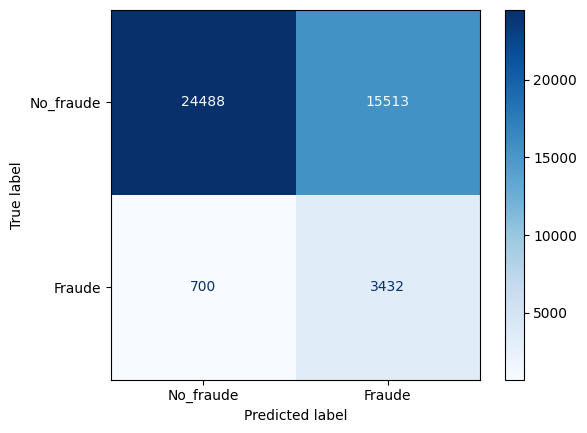

Accuracy en el conjunto de prueba: 0.6326331769877416
Recall en el conjunto de prueba: 0.8305905130687319


In [58]:
# Obtenemos nuestras metricas
test_acc = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

# tambien obtenemos nuestra matriz de confussion, pero de una forma más llamtiva
matriz_confusion_test = confusion_matrix(y_test, y_test_pred)

# Visualización de la matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion_test,
                                    display_labels=['No_fraude', 'Fraude']) # Reemplaza con tus etiquetas
cm_display.plot(cmap=plt.cm.Blues)
plt.show()


print(f"Accuracy en el conjunto de prueba: {test_acc}")
print(f"Recall en el conjunto de prueba: {test_recall}")


Ahí esta un ejemplo de como se comportaría nuestro pipeline final con datos no vistos. Lo que podemos concluir de ésta técnica, es que nuestros datos quiza tengan conexiones más complejas, que la regresión logistica no alcanza a ver bien, así que vamos a probar con un Ramndom Forest, haber que tal se comportan nuestros datos.

No salvamos el modelo, porque sinceramente no tuvo un buen rendieminto, no deberíamos considerarlo para producción, estamos esperando mejores resultados.